# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact_manual
# Display Setting 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
#Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Raeading data from csv file to pandas dataframe
df=pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.6,C1231006815,170136.0,160296.4,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.3,C1666544295,21249.0,19384.7,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.1,C2048537720,41554.0,29885.9,M1230701703,0.0,0.0,0,0


In [3]:
#Checking value counts of positive and negative data to have the idea of skewness of data
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As we see there are too many examples of not fraud data in compare to fradulent one so we will use equal amount of both to carry out our investigation

So we will choose 10k of not fraudulent data examples from 6354407 and all 8213 fraudlent data to eliminate skewness.

In [31]:
data_neg=df[df['isFraud']==0].sample(10000)   #Choosing randomly 10000 negative examples with isFraud column value equal to 0
dataset=df[df['isFraud']==1]
dataset=dataset.append(data_neg)
dataset.isFraud.value_counts()

0    10000
1     8213
Name: isFraud, dtype: int64

In [32]:
df2=dataset.copy()
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [7]:
dataset.info()    #Getting info of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18213 entries, 2 to 630891
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            18213 non-null  int64  
 1   type            18213 non-null  object 
 2   amount          18213 non-null  float64
 3   nameOrig        18213 non-null  object 
 4   oldbalanceOrg   18213 non-null  float64
 5   newbalanceOrig  18213 non-null  float64
 6   nameDest        18213 non-null  object 
 7   oldbalanceDest  18213 non-null  float64
 8   newbalanceDest  18213 non-null  float64
 9   isFraud         18213 non-null  int64  
 10  isFlaggedFraud  18213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.7+ MB


So our dataset now contain 18213 entries

In [8]:
dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,18213.0,18213.0,18213.0,18213.0,18213.0,18213.0,18213.0,18213.0
mean,301.0,756352.1,1187369.7,542252.2,851377.4,1246114.0,0.5,0.0
std,190.1,1792683.0,3201369.7,2522309.1,3334639.5,3705175.9,0.5,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,161.0,31061.2,6338.0,0.0,0.0,0.0,0.0,0.0
50%,282.0,157494.6,99165.1,0.0,0.0,132247.3,0.0,0.0
75%,403.0,468638.0,697226.2,0.0,549138.9,1089947.0,1.0,0.0
max,743.0,37014676.3,59585040.4,49585040.4,236230516.8,236726494.7,1.0,1.0


In [11]:
dataset.duplicated().value_counts()   #Checking for data duplication

False    18213
dtype: int64

No data is duplicated

# Now its time to manually iterate to each feature and filter out best ones

## Step Column

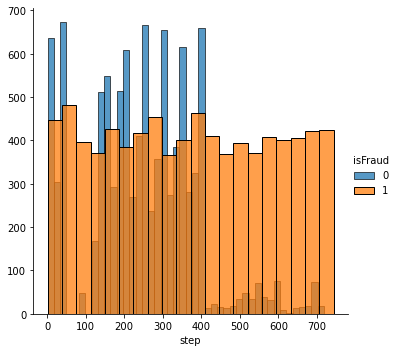

In [9]:
sns.FacetGrid(dataset,hue="isFraud",height=5).map(sns.histplot,'step').add_legend()    #Histogram

This clearly indicate that there is no relation of happening of fraud and the steps it took to carrry out transaction because it happened with almost every value of step so we can eliminate this column as it does not add any information to our data.

## Type Column

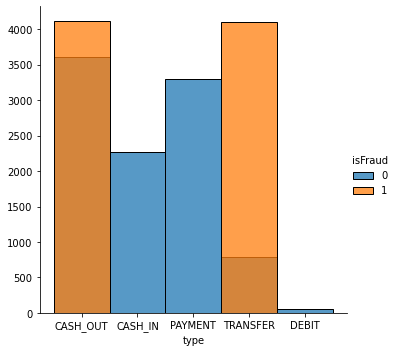

In [10]:
sns.FacetGrid(dataset,hue="isFraud",height=5).map(sns.histplot,'type').add_legend()        #Histogram

It can be seen that we can sepearate out that if transaction took place via Cash_In,Payment or Debit then there is no chance of it being fraudulent

## Amount Column

Amount varies greatly so to visualize it we have to devide it into bins.

In [11]:
dataset["amount"].describe()

count      18213.0
mean      759153.8
std      1798434.5
min            0.0
25%        33151.5
50%       161147.4
75%       463972.7
max     34798476.9
Name: amount, dtype: float64

Buckezing amount column

<AxesSubplot:xlabel='amount', ylabel='Count'>

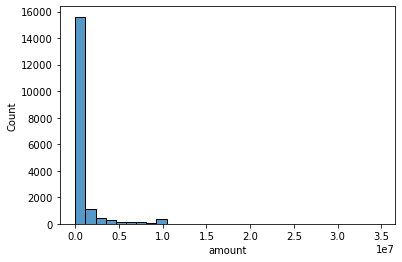

In [12]:
sns.histplot(dataset.amount,bins=30)              #Histogram with bins

In [14]:
amount_freq=dataset['amount'].value_counts(bins=30).array
print(amount_freq)

<PandasArray>
[15613,  1090,   442,   332,   252,   155,   126,   120,    78,     1,     1,
     1,     1,     1,     0,     0,     0,     0,     0,     0,     0,     0,
     0,     0,     0,     0,     0,     0,     0,     0]
Length: 30, dtype: int64


All most half of the amount of transaction is within 2 million

<AxesSubplot:xlabel='amount', ylabel='Count'>

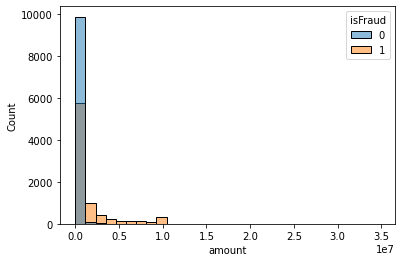

In [31]:
sns.histplot(x=dataset.amount,hue=dataset["isFraud"],bins=30)

Fraud is mainly not occuring if the amount of transaction is less hence this feature is an informative one to detect fraud

## Name of customer

In [32]:
dataset['nameOrig'].duplicated().value_counts()  #Checking for duplicates in name of origin

False    18213
Name: nameOrig, dtype: int64

No duplication

In [33]:
dataset[dataset['isFraud']==1]["nameOrig"]

2          C1305486145
3           C840083671
251        C1420196421
252        C2101527076
680         C137533655
              ...     
6362615     C786484425
6362616    C1529008245
6362617    C1162922333
6362618    C1685995037
6362619    C1280323807
Name: nameOrig, Length: 8213, dtype: object

There is no common charecteristics in the name of fradulent cutomer senders name, so we can eliminate this column

In [34]:
dataset['nameDest'].duplicated().value_counts()   #Cheking for duplication in name of destination

False    17990
True       223
Name: nameDest, dtype: int64

Name of destination is being duplicated 223 times this may lead to some pattern but its too small to affect our model accuracy

## Customer Balance

Their are two columns for balance of customer who started transaction and for those who are the recepient , so it will be better to create a extra feature instead of old and new balance we can put change in balance, it decrease our size of data and also add more information to our dataset.

In [33]:
change_balance_org=dataset['newbalanceOrig']-dataset['oldbalanceOrg']  #Converting balance of origin customer
temp=pd.DataFrame(change_balance_org,columns=['change_cust_balance'])
dataset=dataset.join(temp)

In [34]:
change_balance_dest=dataset['newbalanceDest']-dataset['oldbalanceDest']  #Convrting balance of recepient customer
temp2=pd.DataFrame(change_balance_dest,columns=['change_dest_balance'])
dataset=dataset.join(temp2)

Removing oldbalanceOrg , newbalanceOrig ,oldbalaceDest , newbalanceDest and step columns

In [35]:
dataset=dataset.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig'],axis=1)

To carry out vizualization more precisely lets just work on 'type' = Cash_out and Transfer as these are the two modes of transaction in which fraud has occured

In [36]:
d1=dataset[dataset['type']=='CASH_OUT']

In [37]:
d2=dataset[dataset['type']=='TRANSFER']

In [38]:
new_dataset=d1.append(d2)

In [39]:
new_dataset

,type,amount,nameDest,isFraud,isFlaggedFraud,change_cust_balance,change_dest_balance
3,CASH_OUT,181.0,C38997010,1,0,-181.0,-21182.0
252,CASH_OUT,2806.0,C1007251739,1,0,-2806.0,-26202.0
681,CASH_OUT,20128.0,C339924917,1,0,-20128.0,5877.9
724,CASH_OUT,416001.3,C667346055,1,0,0.0,9291517.6
970,CASH_OUT,1277212.8,C716083600,1,0,-1277212.8,2444985.2
...,...,...,...,...,...,...,...
828668,TRANSFER,747495.6,C639695157,0,0,0.0,915053.2
3411176,TRANSFER,415235.4,C1586025677,0,0,-2617.0,415235.4
3734099,TRANSFER,500501.4,C2084684851,0,0,-101545.8,788348.2
1191031,TRANSFER,710125.0,C1707583711,0,0,-106275.0,710125.0


#### Lets start with visualizing data from d1 dataset with type as Cash-out

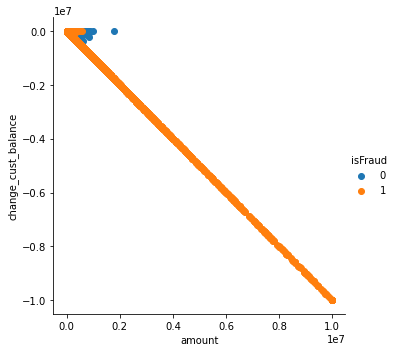

In [40]:
sns.FacetGrid(d1,hue='isFraud',height=5).map(plt.scatter,'amount','change_cust_balance').add_legend()

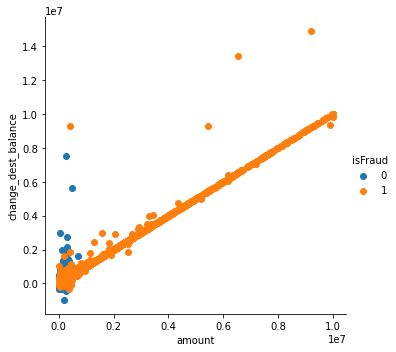

In [41]:
sns.FacetGrid(d1,hue='isFraud',height=5).map(plt.scatter,'amount','change_dest_balance').add_legend()

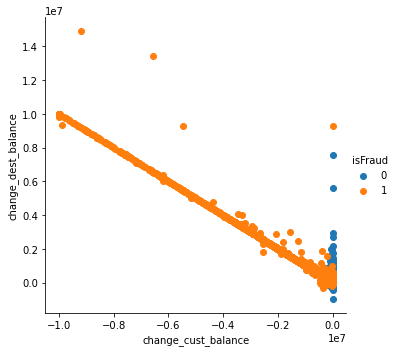

In [42]:
sns.FacetGrid(d1,hue='isFraud',height=5).map(plt.scatter,'change_cust_balance','change_dest_balance').add_legend()

#### Now dataset with type Transfer

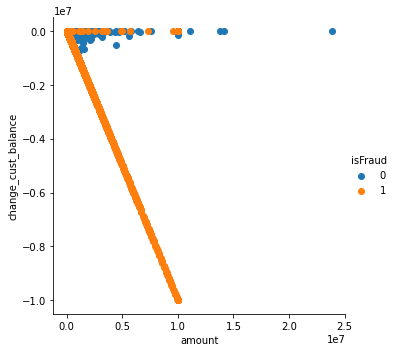

In [43]:
sns.FacetGrid(d2,hue='isFraud',height=5).map(plt.scatter,'amount','change_cust_balance').add_legend()

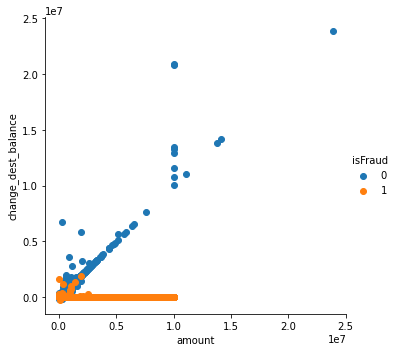

In [44]:
sns.FacetGrid(d2,hue='isFraud',height=5).map(plt.scatter,'amount','change_dest_balance').add_legend()

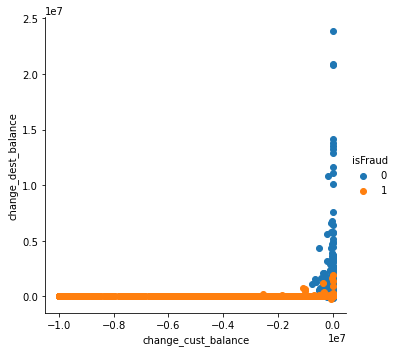

In [45]:
sns.FacetGrid(d2,hue='isFraud',height=5).map(plt.scatter,'change_cust_balance','change_dest_balance').add_legend()

Amount
Change_cust_balance
Change_dest_balance
are important columns as they are forming patterns to separate data

## isFlaggedFraud Column

In [46]:
dataset['isFlaggedFraud'].value_counts()

0    18197
1       16
Name: isFlaggedFraud, dtype: int64

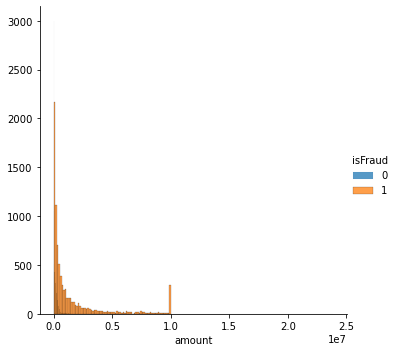

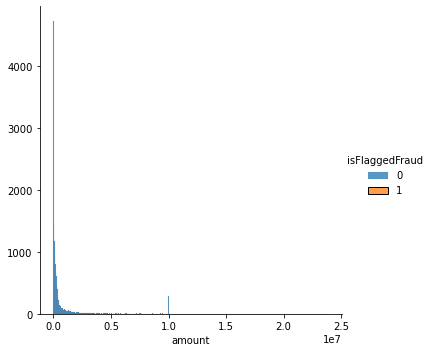

In [47]:
sns.FacetGrid(dataset,hue="isFraud",height=5).map(sns.histplot,'amount').add_legend()
sns.FacetGrid(dataset,hue="isFlaggedFraud",height=5).map(sns.histplot,'amount').add_legend()

isFlaggedFraud column is not helping much and it only flagged out 16 data points which will not help much in our detection so we will remove this feature too

In [50]:
dataset=dataset.drop('isFlaggedFraud',axis=1)  #Removing isFlaggedFraud feature

In [51]:
dataset

,type,amount,nameDest,isFraud,change_cust_balance,change_dest_balance
2,TRANSFER,181.0,C553264065,1,-181.0,0.0
3,CASH_OUT,181.0,C38997010,1,-181.0,-21182.0
251,TRANSFER,2806.0,C972765878,1,-2806.0,0.0
252,CASH_OUT,2806.0,C1007251739,1,-2806.0,-26202.0
680,TRANSFER,20128.0,C1848415041,1,-20128.0,0.0
...,...,...,...,...,...,...
4222356,CASH_OUT,7245.4,C546932829,0,0.0,7245.4
5059232,PAYMENT,14318.7,M729383434,0,-14318.7,0.0
385514,PAYMENT,17502.7,M1868804880,0,0.0,0.0
1265975,CASH_IN,112760.0,C1442476697,0,112760.0,-112760.0


# Feature Engineering

In [52]:
dataset=dataset.sample(frac=1).reset_index(drop=True)
dataset

,type,amount,nameDest,isFraud,change_cust_balance,change_dest_balance
0,CASH_OUT,101013.3,C463938761,1,-101013.3,101013.3
1,PAYMENT,3592.6,M2012729037,0,-3592.5,0.0
2,CASH_IN,60518.0,C1642953562,0,60518.0,-60518.0
3,CASH_IN,388302.7,C1521571660,0,388302.7,161788.8
4,TRANSFER,48516.9,C116841547,1,-48516.9,0.0
...,...,...,...,...,...,...
18208,TRANSFER,44116.9,C1952007189,1,-44116.9,0.0
18209,TRANSFER,257988.5,C364328277,1,-257988.5,0.0
18210,CASH_OUT,412511.3,C33412994,1,-412511.3,412511.3
18211,CASH_IN,32268.5,C1507003492,0,32268.5,-32268.5


Shuffling the data

In [62]:
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': dataset, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

## Missing Values

There is no missing values

## Outliers

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

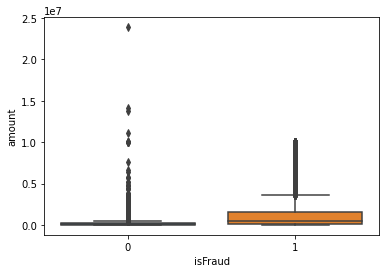

In [63]:
sns.boxplot(x='isFraud',y='amount',data=dataset)

<AxesSubplot:xlabel='isFraud', ylabel='change_cust_balance'>

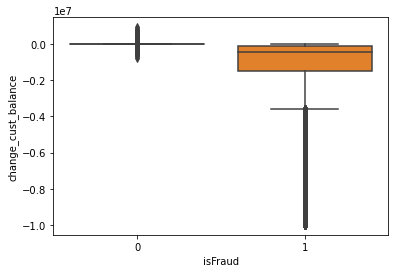

In [64]:
sns.boxplot(x='isFraud',y='change_cust_balance',data=dataset)

<AxesSubplot:xlabel='isFraud', ylabel='change_dest_balance'>

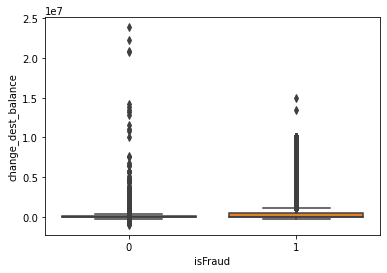

In [65]:
sns.boxplot(x='isFraud',y='change_dest_balance',data=dataset)

As data varies too much we cannot separate out outliers from it

## Multicollinearity

<AxesSubplot:>

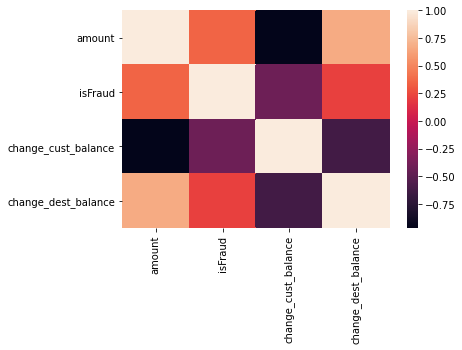

In [66]:
sns.heatmap(dataset.corr())

Using VIF to detect multicollinearity

In [67]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [68]:
def get_VIF(dataFrame , target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

In [69]:
target = 'isFraud'
print(get_VIF(dataset.drop(['type','nameDest'],axis=1),target))

const                  1.2
amount                17.4
change_cust_balance   15.4
change_dest_balance    1.9
dtype: float64


There is collinearity between amount and change_cust_balance but its not huge so lets try building without removing multi-collinearity from there two columns as they are the important ones and we cannot just drop these two columns

## Changing categorical column to numeric

In [70]:
vocab={'type':{'CASH_OUT':0,'TRANSFER':1,'CASH_IN':2,'PAYMENT':3,'DEBIT':4}}

In [71]:
dataset.replace(vocab,inplace=True)

In [72]:
dataset

,type,amount,nameDest,isFraud,change_cust_balance,change_dest_balance
0,0,101013.3,C463938761,1,-101013.3,101013.3
1,3,3592.6,M2012729037,0,-3592.5,0.0
2,2,60518.0,C1642953562,0,60518.0,-60518.0
3,2,388302.7,C1521571660,0,388302.7,161788.8
4,1,48516.9,C116841547,1,-48516.9,0.0
...,...,...,...,...,...,...
18208,1,44116.9,C1952007189,1,-44116.9,0.0
18209,1,257988.5,C364328277,1,-257988.5,0.0
18210,0,412511.3,C33412994,1,-412511.3,412511.3
18211,2,32268.5,C1507003492,0,32268.5,-32268.5


#### Now for nameDest column

In [74]:
from sklearn.preprocessing import LabelEncoder   #Using Labal Encoder for encoding our nameDest column
le=LabelEncoder()
encoded_name=le.fit_transform(dataset['nameDest'])
dataset['encoded_nameDest']=encoded_name

In [76]:
dataset=dataset.drop('nameDest',axis=1)
dataset

,type,amount,isFraud,change_cust_balance,change_dest_balance,encoded_nameDest
0,0,101013.3,1,-101013.3,101013.3,10456
1,3,3592.6,0,-3592.5,0.0,16307
2,2,60518.0,0,60518.0,-60518.0,4764
3,2,388302.7,0,388302.7,161788.8,3868
4,1,48516.9,1,-48516.9,0.0,1219
...,...,...,...,...,...,...
18208,1,44116.9,1,-44116.9,0.0,7100
18209,1,257988.5,1,-257988.5,0.0,9705
18210,0,412511.3,1,-412511.3,412511.3,9482
18211,2,32268.5,0,32268.5,-32268.5,3768


# Building Model

In [77]:
X=dataset.drop('isFraud',axis=1)
Y=dataset['isFraud']
print(X.shape,Y.shape)

(18213, 5) (18213,)


### Standardizing data

In [78]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)

### Splitting data

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(standardized_data,Y,test_size=0.33,random_state=40)

In [80]:
X_tr,X_cv,Y_tr,Y_cv=train_test_split(X_train,Y_train,test_size=0.33,random_state=40)

In [81]:
print(X_tr.shape,X_cv.shape,X_test.shape)

(8175, 5) (4027, 5) (6011, 5)


## Using Logistic Regression

Now first we will use simple logistic regression to fit our dataset

In [86]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,Y_train)                  #Fitting logisitc regression model to our data

LogisticRegression()

In [87]:
print("SCORE",lr.score(X_test,Y_test))    #Printing score

SCORE 0.9231409083347197


As we can see simple logistic regression model is also soing great job in prediciting fraud with accuracy 92.31%

## Logistic Regression with Grid search CV

Now lets tweak our logistic model little bit and use grid search cross validation to estimate best values of our hyperparameters and tune our model according to the estimated values

In [99]:
from sklearn.model_selection import GridSearchCV        #importing gridsearchCV
tuned_param=[{'C':[10**-4,10**-2, 10**0, 10**2, 10**4]}]    #Giving list of possible values of hyperparameters
lr_gs=GridSearchCV(LogisticRegression(solver='liblinear'),tuned_param,scoring='f1',cv=3)

In [100]:
lr_gs.fit(X_train,Y_train)             #Fitting model

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}], scoring='f1')

In [101]:
lr_gs.best_estimator_                #Estimated value of hyperparameter

LogisticRegression(C=10000, solver='liblinear')

In [102]:
print("SCORE",lr_gs.score(X_test,Y_test))

SCORE 0.9324995401876034


It improved our accuracy to 93.24%

## Using Neural Network

In [113]:
#creating model
def create_model(my_learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=10,                        #First hidden layer with 10 hidden units , we are using
                                  activation='relu',# activation function Relu(Rectified Linear Unit) , this
                                  name='Hidden1'))                   # works best in hidden layer as it add non linearity to 
#     model.add(tf.keras.layers.Dense(units=10,                      #our model
#                                       activation='tanh',            
#                                       name='Hidden2'))
    model.add(tf.keras.layers.Dense(units=1,                         #Output layer with 1 hidden unit and sigmoid activation
                                  name='Output',activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="binary_crossentropy",                          #We have chosen binary_cross entropy as it works best for
                metrics=['accuracy'])                                #binary classification
    return model

In [104]:
#Training model
def train_model(model, dataset, epochs, label_name, batch_size, validation_split,shuffle=True):
    history = model.fit(x=dataset, y=label_name, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
    epochs = history.epoch                                   #We retrun epochs and history to plot curve
    hist = pd.DataFrame(history.history)
    return epochs,history

In [105]:
def plot_curve(epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:                                     #Plotting curve Epoch vs Metrics(which is accuracy)
        x = hist.history[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

Epoch 1/100
977/977 [==============================] - 2s 1ms/step - loss: 0.6636 - accuracy: 0.5365 - val_loss: 0.4296 - val_accuracy: 0.7444
Epoch 2/100
977/977 [==============================] - 1s 1ms/step - loss: 0.4083 - accuracy: 0.7705 - val_loss: 0.3339 - val_accuracy: 0.8501
Epoch 3/100
977/977 [==============================] - 1s 1ms/step - loss: 0.3164 - accuracy: 0.8761 - val_loss: 0.2715 - val_accuracy: 0.9140
Epoch 4/100
977/977 [==============================] - 1s 1ms/step - loss: 0.2661 - accuracy: 0.9193 - val_loss: 0.2282 - val_accuracy: 0.9226
Epoch 5/100
977/977 [==============================] - 1s 1ms/step - loss: 0.2263 - accuracy: 0.9224 - val_loss: 0.2001 - val_accuracy: 0.9259
Epoch 6/100
977/977 [==============================] - 1s 1ms/step - loss: 0.2025 - accuracy: 0.9249 - val_loss: 0.1851 - val_accuracy: 0.9201
Epoch 7/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1833 - accuracy: 0.9251 - val_loss: 0.1701 - val_accuracy: 0.9299

Epoch 58/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1081 - accuracy: 0.9591 - val_loss: 0.1071 - val_accuracy: 0.9603
Epoch 59/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1019 - accuracy: 0.9672 - val_loss: 0.1071 - val_accuracy: 0.9639
Epoch 60/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1077 - accuracy: 0.9599 - val_loss: 0.1091 - val_accuracy: 0.9496
Epoch 61/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1033 - accuracy: 0.9595 - val_loss: 0.1080 - val_accuracy: 0.9607
Epoch 62/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1100 - accuracy: 0.9571 - val_loss: 0.1065 - val_accuracy: 0.9631
Epoch 63/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1088 - accuracy: 0.9602 - val_loss: 0.1060 - val_accuracy: 0.9627
Epoch 64/100
977/977 [==============================] - 1s 1ms/step - loss: 0.1075 - accuracy: 0.9584 - val_loss: 0.1063 - val_accuracy:

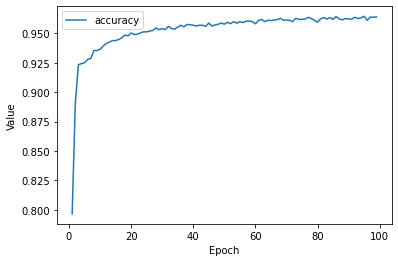

In [129]:
learning_rate = 0.001                         #Learning rate for adam optimizer
epochs = 100                                  #number of epochs
batch_size = 10                               #Batch size
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, X_train, 
                           epochs,Y_train ,batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [130]:
my_model.evaluate(x=X_test, y=Y_test, batch_size=batch_size)

602/602 [==============================] - 1s 870us/step - loss: 0.1029 - accuracy: 0.9656


[0.10288887470960617, 0.9655631184577942]

Neural network killed it, it is the best accuracy so far with 96.55%

## Using K nearest neighbors

Now lets try with k nearest neighbors

accuracy for 1 is 94
accuracy for 3 is 94
accuracy for 5 is 94
accuracy for 7 is 94
accuracy for 9 is 94
accuracy for 11 is 93
accuracy for 13 is 93
accuracy for 15 is 93
accuracy for 17 is 93
accuracy for 19 is 93
accuracy for 21 is 93
accuracy for 23 is 92
accuracy for 25 is 92
accuracy for 27 is 92
accuracy for 29 is 92


<AxesSubplot:>

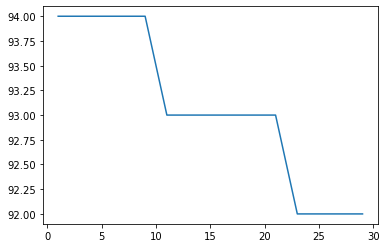

In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
acc=np.arange(30)

for i in range(1,30,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_tr,Y_tr)
    pred=knn.predict(X_cv)
    accuracy=accuracy_score(Y_cv,pred)*float(100)
    print("accuracy for %d is %d" % (i,accuracy))
    acc[i]=accuracy

i_arr=np.zeros(15)
acc_arr=np.zeros(15)

j=0
for i in range(1,30,2):
    i_arr[j]=i
    acc_arr[j]=acc[i]
    j+=1
    

sns.lineplot(i_arr,acc_arr)

Max accuracy is obtained with number of neighbors=1 to 9

In [138]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_tr,Y_tr)
pred=knn.predict(X_test)
print("ACCURACY",accuracy_score(Y_test,pred)*float(100))

ACCURACY 94.16070537348195


## KNN with 10 fold cross validation

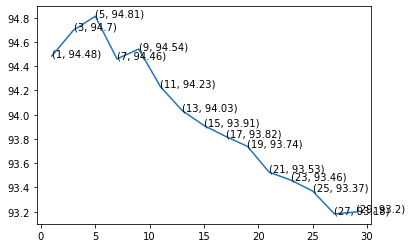

In [139]:
from sklearn.model_selection import cross_val_score
neighbors=[i for i in range(0,30) if i%2!=0 ]

cv_scores=[]

#Fitting n with diffrent values of n
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,X_train,Y_train,cv=10,scoring='accuracy')
    cv_scores.append(score.mean()*float(100))
    
#Plotting curve N vs Accuracy
plt.plot(neighbors,cv_scores)
for xy in zip(neighbors,np.round(cv_scores,2)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

Best at number of neighbors = 5

In [147]:
knn=KNeighborsClassifier(n_neighbors=3)   #By experimenting it is found that with n=3 it do the better job
knn.fit(X_train,Y_train)
pred=knn.predict(X_test)                  #Predicting 
print("ACCURACY",accuracy_score(Y_test,pred)*float(100))

ACCURACY 94.60988188321411


#### So neural network it is, which did the best job

# Fraud detection model

* Neural network with 1 hidden layer with 10 hidden units can detect fraud with 96.55% accuracy.
* This model basically just use activation function Relu in hidden layer as it add non-lenearity to our model which helps to learn different characteristic of our data and to predict better.Sigmoid is used at output layer.
* Validation split with 0.2.
* Learning rate of 0.001 is chosen with highest accuracy and it helped our 'adam' optimizer to converge at best accuracy and minimum loss.
* Model is trained on 100 epochs and with every epoch we plot epochs vs accuracy curve to visualize behaviour of convergence of our model.
* Batch size of 10 is chosen.

# Key factors for fraud detection

* Amount and change in balance of cutomers are the major factors for fraud detection
* It is also seen that type of mode of transaction plays an important role as well.
* Almost every fraud occured when transaction is completed using Cash_out and transfer mode.
* If the amount of transaction is less than there is less chances of fraud to occur.

# Prevention for company to adapt

* First of all ,have an eye on those transaction involving huge amount of money.
* Two factor authentication is also do good for these type of transaction.
* And the warning message should pop to the customer on whoose account this transaction is being carried out.
* Can also implement a threshold in the amount of transaction.
* As we have seen some customers are being involved in fraud more than once so it would be advised to keep a record of those customers which are being involved in fraud first time , so to stop it from happening(if it do) next time.
* Increase the value of isFlaggedFraud to 1k - 5k.

# Determining the working of these actions

* Adding two factor authentication is easy. Just create a database of those customers to which two factor authentication violates the transaction.
* Increaing value of isFlaggedFraud helps greatly to predict possibility of fraud.
* Set the limit in amount of transaction and by setting it stores data of customer separately to keep a track on transaction.